### Applying the GMM heterogeneity analysis to subtomogram averaging
This uses a single model refinement (using the new pipeline) of the ribosome from the EMPIAR-10064 dataset. A neutral Gaussian model is already generated from the averaged structure, and here we look at the continuous movement of the particles. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from EMAN2 import *

In [2]:
#### select one GPU when multiple GPUs are present
os.environ["CUDA_VISIBLE_DEVICES"]='0' 

#### do not occupy the entire GPU memory at once
##   seems necessary to avoid some errors...
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]='true' 

#### finally initialize tensorflow
import tensorflow as tf

In [3]:
#### we will import some functions from e2gmm_refine later
emdir=e2getinstalldir()
sys.path.insert(0,os.path.join(emdir,'bin'))

#### need to unify the float type across tenforflow and numpy
##   in theory float16 also works but it can be unsafe especially when the network is deeper...
floattype=np.float32

In [4]:
#### load the Gaussian model produced by e2gmm_refine.py
from e2gmm_refine import get_clip

pts=np.loadtxt("gmm_00/model_00.txt").astype(floattype)
print("Gaussian model shape: ", pts.shape)

##   turn model to tensorflow format
pts=tf.constant(pts[None,:,:])

Gaussian model shape:  (1015, 5)


In [6]:
#### load particles and prepare some parameters
from e2gmm_refine import load_particles, set_indices_boxsz
fname="gmm_00/ref_projs.hdf"

##  Fourier box size. will shrink particles accordingly
maxboxsz=48 

##   load metadata first
e=EMData(fname, 0, True)
raw_apix, raw_boxsz = e["apix_x"], e["ny"]
data_cpx, xfsnp = load_particles(fname, maxboxsz, shuffle=False)

print("Image size: ", data_cpx[0].shape)

##   set up fourier indices for image generation/clipping later
##   params is a dictionay that saves matrices for Fourier indexing
apix=raw_apix*raw_boxsz/maxboxsz
clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)

##   create an empty options object that is needed for some functions in e2gmm_refine
options=type('options', (object,), {})()
options.sym="c1"

Loading 833 particles of box size 192. shrink to 48
833/833    
Data read complete
Image size:  (833, 48, 25)


0.93224263


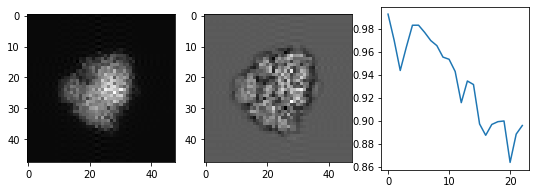

In [7]:
#### now generate some images to make sure everything is working properly
from e2gmm_refine import pts2img, calc_frc

sz=params["sz"]    ## size of image
bsz=8              ## batch size

##   generate a batch of projection images from the GMM at neutral state
##   pts2img produce complex images in (real, imag) format
##   turn them into complex numbers and IFT to get the real images
ptsx=tf.Variable(tf.repeat(pts, bsz, axis=0))
imgs_real, imgs_imag=pts2img(ptsx, xfsnp[:bsz], params, lp=.05)
imgs_cpx=imgs_real.numpy().astype(floattype)+1j*imgs_imag.numpy().astype(floattype)
imgs_out=np.fft.irfft2(imgs_cpx)

##   just show one projection-particle comparison
ii=1
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.imshow(imgs_out[ii], cmap='gray')

##   get the complex particle image and IFT to real space
dcpx=(data_cpx[0][:bsz], data_cpx[1][:bsz])
dcpx=get_clip(dcpx, sz, clipid)
dcpx_out=np.fft.irfft2(dcpx[0].numpy()+1j*dcpx[1].numpy())

plt.subplot(1,3,2)
plt.imshow(dcpx_out[ii], cmap='gray')

##   calculate FRC between particle and projection
##   the calc_frc function takes complex images in (real, imag) format
frc=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"], True)
plt.subplot(1,3,3)
plt.plot(frc[ii][1:])
fval=calc_frc(dcpx, (imgs_real, imgs_imag), params["rings"])
print(np.mean(fval))

In [13]:
#### load the alignment from spt refinement
##   make sure we have only one conformation for multiple 2D particles that correspond to one 3D particle
alipm=load_lst_params("gmm_00/aliptcls2d_00.lst")
pids=np.array([a["ptcl3d_id"] for a in alipm])
tids=np.array([a["tilt_id"] for a in alipm])

##   here we only use the near center tilts (-20 to +20 degrees)
tmid=np.sort(np.unique(tids))
tmid=tmid[len(tmid)//2]
trg=abs(tids-tmid)<10

##   keep track of 3D particles from the 2D ones
idx=np.unique(pids)
idx3d=[]
for i in idx:
    idx3d.append(np.where(trg*(pids==i))[0])

print("{} 3D particles, each contain {} 2D particles".format(len(idx3d), len(idx3d[0])))

4194 3D particles, each contain 19 2D particles


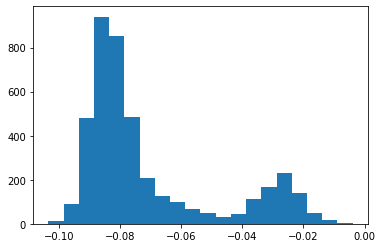

In [14]:
#### also look at the alignment score and remove the bad particles
scr=[]
for idx in idx3d:
    s=np.mean([alipm[i]["score"] for i in idx])
    scr.append(s)
    
plt.hist(scr,20);

In [31]:
#### initialize some parameters
batchsz=4
thr=-0.05
i3d=[ix for i,ix in enumerate(idx3d) if scr[i]<thr]

##   there are some issues when we do not have a full batch of particles
##   so we skip the last few particles
n=len(i3d)//batchsz*batchsz
i3d=i3d[:n]
print("Keeping {} particles".format(len(i3d)))

##   box size and apix
a=alipm[0]
e=EMData(a["src"], a["idx"], True)
by=e["ny"]
ny=e["ny"]//2

e=EMData(fname, 0, True)
raw_apix, raw_boxsz = e["apix_x"], e["ny"]
apix=raw_apix*raw_boxsz/maxboxsz
clipid=set_indices_boxsz(data_cpx[0].shape[1], apix, True)
params=set_indices_boxsz(maxboxsz)
print("2D particle size {}, clip to {}".format(by, ny))

Keeping 3400 particles
2D particle size 384, clip to 192


In [27]:
#### now reading actual particles and organize them correctly
xfsnp=[]  ## particle projections transforms
ptcls=[]  ## 2d particle images
p3did=[]  ## indices of 2d particles for each 3d particle
apmsample=[]  ## the alignment metadata of the particles

for idx in i3d:
    apm=[alipm[i] for i in idx]
    apmsample.extend(apm)
    
    pn=np.sum([len(p) for p in ptcls])
    p3did.append(np.arange(pn, pn+len(apm), dtype=int))
    
    ## 2D particles are extra padded. here need to clip them to the 3d particle size
    imgs=[EMData(a["src"], a["idx"]) for a in apm]
    imgs=[m.get_clip(Region((by-ny)//2, (by-ny)//2, ny,ny)) for m in imgs]
    imgs=np.array([p.numpy().copy() for p in imgs], dtype=floattype)/1e3
    
    ## projection transforms
    xfs=[a["xform.projection"].get_params("eman") for a in apm]
    xfs=np.array([[x["az"],x["alt"],x["phi"], x["tx"], x["ty"]] for x in xfs], dtype=floattype)
    xfs[:,:3]=xfs[:,:3]*np.pi/180.
    xfs[:,3:]/=ny
    
    ptcls.append(imgs)
    xfsnp.append(xfs)
    
    sys.stdout.write("\r {}/{}      ".format(len(ptcls), len(i3d)))
    sys.stdout.flush()    

print()
print("Read {} 2D particles.".format(np.sum([len(p) for p in ptcls])))

 3400/3400      
Read 64600 2D particles.


In [32]:
#### now put together particle images and xforms
ptcls=np.concatenate(ptcls, axis=0)
xfsnp=np.concatenate(xfsnp, axis=0)

##   Fourier transform and clipping
data_cpx=np.fft.rfft2(ptcls)
data_cpx=(data_cpx.real.astype(floattype), data_cpx.imag.astype(floattype))
dcpx=get_clip(data_cpx, sz, clipid)
print("Particle image shape ", dcpx[0].shape)

Particle image shape  (64600, 48, 25)


In [35]:
#### calculating gradient per 3d particle
##   use information from 2d particles but compute one gradient per 3d particle
conf=np.zeros((1,4), dtype=floattype)
allgrds=[]
allscr=[]

##   treat 2d particles of one 3d particle as a batch for gradient
for pid in p3did:
    pjr=tf.gather(dcpx[0], pid)
    pji=tf.gather(dcpx[1], pid)
    xf=xfsnp[pid]
    pj_cpx=(pjr, pji)
    with tf.GradientTape() as gt:
        pt=tf.Variable(pts)
        
        imgs_cpx=pts2img(tf.repeat(pt, xf.shape[0], axis=0), xf, params)
        fval=calc_frc(pj_cpx, imgs_cpx, params["rings"])
        loss=-tf.reduce_mean(fval)

    grad=gt.gradient(loss, pt)
    allscr.append(loss)
    allgrds.append(grad)
    sys.stdout.write("\r {}/{}      ".format(len(allgrds), len(p3did)))
    sys.stdout.flush()
    
allgrds=np.concatenate(allgrds, axis=0)
allgrds=allgrds/np.std(allgrds)
print(allgrds.shape)  
print(np.max(abs(allgrds.flatten())))

Instructions for updating:
Use tf.identity instead.
 3400/3400      (3400, 1015, 5)
18.134352


In [72]:
#### rearrange gradient and indices for 3d particles
##   note we repeat gradient of the 3d particle for each 2d particle

batchsz=4 ## here batch size is for 3d particles
batchids=[]
ag=allgrds

nbatch=len(p3did)//batchsz
grds=[]
iis=[]
for i in range(nbatch):
    ii=p3did[i*batchsz:(i+1)*batchsz]

    grd=ag[i*batchsz:(i+1)*batchsz]
    grd=[np.repeat(grd[j:j+1], len(p), axis=0)  for j,p in enumerate(ii)]
    grd=np.concatenate(grd)
    ii=np.concatenate(ii)
    
    grds.append(tf.constant(grd))
    iis.append(tf.constant(ii))
    
print("{} batches total".format(len(grds)))

850 batches total


In [56]:
#### now build the deep networks and do some test
from e2gmm_refine import build_encoder, build_decoder

nmid=4     ## size of latent space
conv=True  ## convolution mode, should be more powerful

##   build the actual network
encode_model=build_encoder(nout=nmid, conv=conv)
decode_model=build_decoder(pts[0].numpy(), ninp=nmid, conv=conv)

##   test the network to make sure they are function properly
##   before training, they should output GMMs that are very close to the neutral GMM
mid=encode_model(allgrds[:bsz])
print("Latent space shape: ", mid.shape)
out=decode_model(mid)
print("Output shape: ",out.shape)
print("Deviation from neutral model: ", np.mean(abs(out-pts)))


Latent space shape:  (8, 4)
Output shape:  (8, 1015, 5)
Deviation from neutral model:  2.7271499e-06


In [57]:
#### neural network training parameters
pas=[1,1,0]
pas=[int(i) for i in pas]
pas=tf.constant(np.array([pas[0],pas[0],pas[0],pas[1],pas[2]], dtype=floattype))

opt=tf.keras.optimizers.Adam(learning_rate=1e-4) 
wts=encode_model.trainable_variables
wts+=decode_model.trainable_variables
xfall=tf.constant(xfsnp)
nbatch=len(p3did)//batchsz

In [58]:
#### Main training loop
for itr in range(5):
    cost=[]
    for i in range(nbatch):
        
        ## gather 2d particle info for the batch of 3d particles
        ## we waste computational power here since the gradient for the same 3d particle would be the same
        ## the encoder/decoder would have the same output for each 3d particle other than the randomness
        ## quite wasting but easier to manage..
        grd=grds[i]
        ii=iis[i]
        pjr=tf.gather(dcpx[0], ii)
        pji=tf.gather(dcpx[1], ii)
        xf=tf.gather(xfall,  ii)
        pj_cpx=(pjr, pji)


        with tf.GradientTape() as gt:
            conf=encode_model(grd, training=True)
            
            ## regularization of the latent layer range
            ## ideally the output is within a 1-radius circle
            ## but we want to make the contraint more soft so it won't affect convergence
            cl=tf.math.sqrt(tf.reduce_sum(conf**2, axis=1))
            cl=tf.reduce_mean(tf.maximum(cl-1,0))
                      
            ## preturb the conformation by a random value
            ## similar to the variational autoencoder, but we do not train the sigma of the random value here
            ## since we control the radius of latent space already, this seems enough
            conf=.1*tf.random.normal(conf.shape)+conf
            pout=decode_model(conf, training=True)
            
            p0=tf.zeros((xf.shape[0],len(pts), 5))+pts
            pout=pout*pas+p0*(1-pas)
            
            ## finally generate images and calculate frc
            imgs_cpx=pts2img(pout, xf, params)
            fval=calc_frc(pj_cpx, imgs_cpx, params["rings"])
            loss=-tf.reduce_mean(fval)+cl*1e-2
        
        cost.append(loss)   
        grad=gt.gradient(loss, wts)
        opt.apply_gradients(zip(grad, wts))
        sys.stdout.write("\r {}/{}\t{:.3f}         ".format(len(cost), nbatch, loss))
        sys.stdout.flush()

    sys.stdout.write("\r")

    print("iter {}, loss : {:.4f}".format(itr, np.mean(cost)))

iter 0, loss : -0.1493  
iter 1, loss : -0.1503  
iter 2, loss : -0.1518  
iter 3, loss : -0.1532  
iter 4, loss : -0.1539  


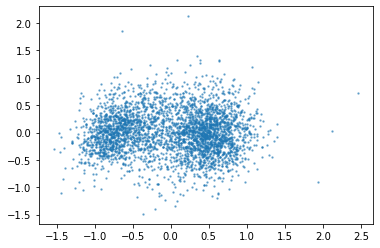

In [63]:
#### look at the latent space
##   here we apply the network to the gradient of 3d particles
from sklearn.decomposition import PCA
mid=encode_model(allgrds)

## do pca on the latent space for better visualization
pca=PCA(2)
p2=pca.fit_transform(mid)

plt.scatter(p2[:,0], p2[:,1],s=2,  alpha=.5)

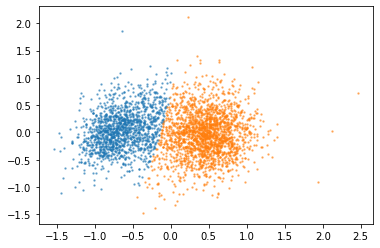

In [64]:
#### classification
from sklearn import mixture
clust = mixture.GaussianMixture(2)
lbs=clust.fit_predict(p2[:,:2])
for l in np.unique(lbs):
    i=lbs==l
    plt.scatter(p2[i,0], p2[i,1],s=2, alpha=.5);

In [65]:
#### generate particles subsets from classification
from EMAN2_utils import load_lst_params, save_lst_params

for l in np.unique(lbs):
    ii=np.where(lbs==l)[0]
    ii=np.concatenate([p3did[i] for i in ii])
    apm=[apmsample[i] for i in ii]
    print("Class {} : {} particles".format(l, len(apm)))
    save_lst_params(apm, "gmm_00/ptcl_cls_{:02d}.lst".format(l))

Class 0 : 26771 particles
Class 1 : 37829 particles


In [66]:
#### reconstruct particles for each class
for i in np.unique(lbs):
    launch_childprocess("e2spa_make3d.py --input gmm_00/ptcl_cls_{:02d}.lst --output gmm_00/threed_cls_{:02d}.hdf --keep 1 --parallel thread:12 --setsf emd_sf.txt --outsize {}".format(i,i, ny))